# Support Vector Machine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [2]:
clean_train = "../data/clean/clean_train.csv"
clean_val = "../data/clean/clean_val.csv"
clean_test = "../data/clean/clean_test.csv"
train_subsam = "../data/clean/train_subsam.csv"
train_smote = "../data/clean/train_smote.csv"
svc_model = "../models/svm_model.joblib"

rnd_svc = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

**Z-Score Scaling**: Algunos algoritmos, como la Regresión Logística y el Support Vector Machine (SVM), funcionan mejor con datos estandarizados, ya que asumen una distribución normal.

In [6]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
366136,45,37,1,0,37,5,1.862365,0.306141,1,0,1,0,0,0,1.985101,2.043450,1.876425,0.230914
264679,4,5,0,7,36,10,2.394265,-0.141224,1,1,1,0,0,0,0.443055,0.479217,0.423189,0.230914
611564,37,40,0,1,38,5,-0.645162,-0.141224,0,1,1,0,0,0,-0.119706,-0.091640,-0.107161,0.230914


## Model Training

### Model Tuning

In [9]:
param_grid = {"kernel": ["poly", "rbf", "sigmoid"],
              "degree": [2, 3, 4],
              "random_state": [rnd_svc]}

In [ ]:
grid_svc = GridSearchCV(SVC(), param_grid, cv=10)
grid_svc.fit(X_train, y_train)

In [ ]:
params = grid_svc.best_params_

print("Better Parameters:", params)

In [7]:
svc_model = SVC(kernel="sigmoid",
                degree=3,
                random_state=rnd_svc)

svc_model.fit(X_train, y_train)

In [ ]:
acc_val = svc_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9479


### Feature Importance

In [ ]:
X_cols = X_train.columns
fi_rfc = rfc_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, fi_rfc)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [ ]:
rfc_ref = RandomForestClassifier(criterion="entropy",
                                 max_depth=20,
                                 random_state=rnd_rfc)

rfe_rfc = RFE(rfc_ref)
rfe_rfc.fit(X_train, y_train)

In [ ]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_rfc.support_, rfe_rfc.ranking_))
rfe_mat

In [ ]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train.loc[:, sel_cols].columns
rfe_cols

In [ ]:
rfc_ref.fit(X_train[rfe_cols], y_train)

In [ ]:
y_ref = rfc_ref.predict(X_val.loc[:,sel_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9379


### Balanced Datasets

**Subsample Dataset**

In [ ]:
rfc_under = RandomForestClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_rfc)
rfc_under.fit(X_under[rfe_cols], y_under)

In [ ]:
acc_under = rfc_under.score(X_val[rfe_cols], y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.8904


**SMOTE Dataset**

In [ ]:
rfc_smote = RandomForestClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_rfc)
rfc_smote.fit(X_smote[rfe_cols], y_smote)

In [ ]:
acc_smote = rfc_smote.score(X_val[rfe_cols], y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.8926


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [ ]:
results = cross_val_score(rfc_ref, X_test[rfe_cols], y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

In [ ]:
y_cv_test = cross_val_predict(rfc_ref, X_test[rfe_cols], y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.9236


**Model Scores**

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(rfc_ref, X_test[rfe_cols], y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Decision Tree Classifier")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [ ]:
y_pred = rfc_ref.predict(X_test[rfe_cols])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9383
Precisión:    0.8964
Sensibilidad: 0.8908
F1-score:     0.8936


In [ ]:
print(classification_report(y_test, y_pred, digits=4))

**Confusion Matrix**

In [ ]:
cm_rfc = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_rfc)

[[0.79329804 0.02923464]
 [0.03246888 0.14499844]]


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                              display_labels=rfc_ref.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

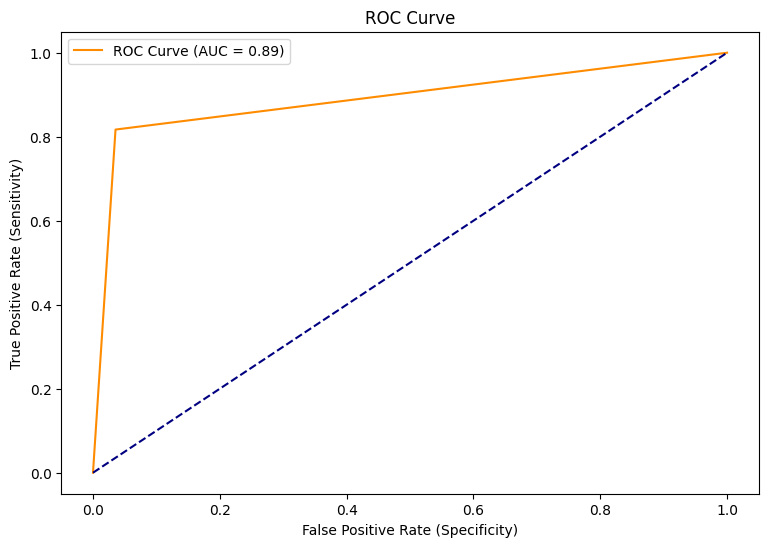

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [ ]:
class RandomForestModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        # self.ranfor = RandomForestClassifier(criterion="entropy",
        #                                      max_depth=20,
        #                                      random_state=rnd_dtc)
        # self.pred_cols = ["State", "BankState", "DifState", "AppYear", "Term",
        #                   "NoEmp", "GrDisburs", "ApprovSBA", "SecuredSBA"]
        pass

    def fit(self, X, y):
        self.ranfor.fit(X[self.pred_cols], y)
        return self

    def predict(self, X, y=None):
        X_ = X[self.pred_cols].copy()
        y_pred = self.ranfor.predict(X_)
        return y_pred

In [ ]:
ranfor_custom = Pipeline([
    ("custom_model", RandomForestModel())
    ])

### Test the Pipeline

**Internal Partition**

In [ ]:
ranfor_custom.fit(X_train, y_train)

y_pred = ranfor_custom.predict(X_val)

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9379
Precisión:    0.8951
Sensibilidad: 0.8908
F1-score:     0.8930


**External Partition**

In [ ]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

ranfor_custom.fit(X_train_val, y_train_val)

y_pred = ranfor_custom.predict(X_test)

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9389
Precisión:    0.8979
Sensibilidad: 0.8912
F1-score:     0.8945


**The Best Model**

In [ ]:
ranfor_custom.fit(X_train_val, y_train_val)

y_pred = ranfor_custom.predict(X_test)

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9389
Precisión:    0.8979
Sensibilidad: 0.8912
F1-score:     0.8945


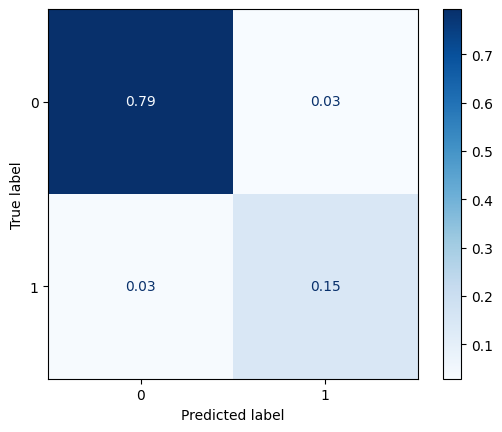

In [ ]:
cm_dtc = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,
                              display_labels=rfc_ref.classes_)
disp.plot(cmap="Blues", values_format=".2f")

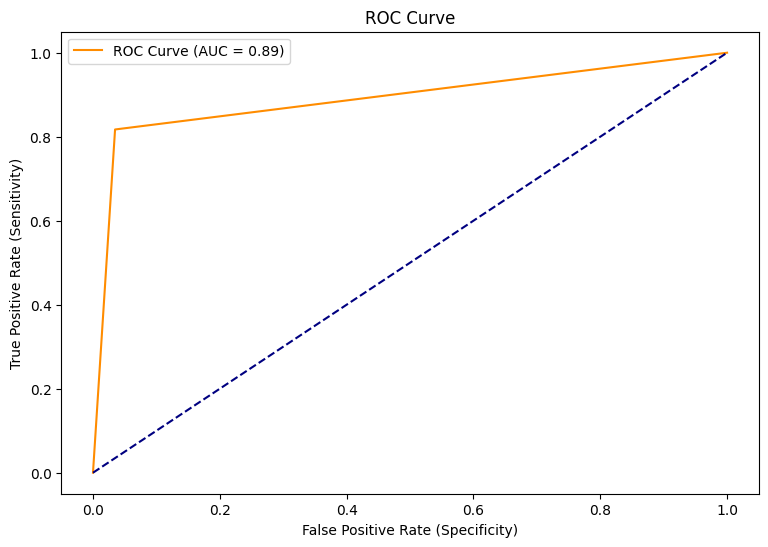

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [ ]:
try:
    joblib.dump(ranfor_custom, ran_for_model)

    ranfor_model = joblib.load(ran_for_model)
    print(f"Random Forest Classifier is loaded...")

except Exception as err:
    print("Error:", str(err))

In [ ]:
y_pred = ranfor_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [ ]:
df_.sample(10)